In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler



In [3]:
df_customer=pd.read_csv("../datasets/olist_customers_dataset.csv")
df_geo=pd.read_csv("../datasets/olist_geolocation_dataset.csv")
df_orders=pd.read_csv("../datasets/olist_orders_dataset.csv")
df_order_items=pd.read_csv("../datasets/olist_order_items_dataset.csv")
df_order_payments=pd.read_csv("../datasets/olist_order_payments_dataset.csv")
df_products=pd.read_csv("../datasets/olist_products_dataset.csv")
df_order_payments=pd.read_csv("../datasets/olist_order_payments_dataset.csv")
df_order_reviews=pd.read_csv("../datasets/olist_order_reviews_dataset.csv")
df_prod_cat_name_trans=pd.read_csv("../datasets/product_category_name_translation.csv")
df_sellers=pd.read_csv("../datasets/olist_sellers_dataset.csv")

In [4]:
# Create a dictionary from 'product_translation' DataFrame for faster lookup
translation_dict = df_prod_cat_name_trans.set_index('product_category_name')['product_category_name_english'].to_dict()

def translate_product_name(category_name):
    """
    Translates the product category name from Portuguese to English.

    Args:
    category_name (str): The product category name in Portuguese.

    Returns:
    str: The product category name in English if translation is available, 
         otherwise returns the original name.
    """
    # Return the translated name if available, otherwise return the original name
    return translation_dict.get(category_name, category_name)

# Apply the translation function to the 'product_category_name' column
df_products['product_category_name'] = df_products['product_category_name'].apply(translate_product_name)

In [5]:
df_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,furniture_decor,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construction_tools_lights,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,bed_bath_table,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,computers_accessories,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [6]:
# Merging the datasets
# We found that in the geolocation dataset, 1 zip code prefix could contain various geolocation latitude and longitude.
# Thus, to merge the geolocation dataset with customers and sellers dataset,
# we will use the first latitude and longitude for each zip code prefix
df_geo_aggregated = df_geo.groupby('geolocation_zip_code_prefix').first().reset_index()

# Dataset that contains customer's info and their location
df_customers = df_customer.merge(df_geo_aggregated,
                                  left_on=['customer_zip_code_prefix'],
                                  right_on=['geolocation_zip_code_prefix'],
                                  how='left').drop(columns=['geolocation_zip_code_prefix'])
print(df_customers)

# Dataset that contains seller info and their location
df_sellers = df_sellers.merge(df_geo_aggregated,
                              left_on=['seller_zip_code_prefix'],
                              right_on=['geolocation_zip_code_prefix'],
                              how='left').drop(columns=['geolocation_zip_code_prefix'])
print(df_sellers)

#dataset that contains the items ordered, item's specification, and the item's seller information
df_order_itemss = df_order_items.merge(df_products, on='product_id',how='left')
print(df_order_itemss)

#dataset that contains order reviews with the latest reviews
#1 order_id could have more than 1 review score. To solve this, we only take into account the latest review score given by the customers. 
# Hence, we will drop the duplicated order id and keeping only the data with the latest review answer timestamp
df_order_reviewss = df_order_reviews.sort_values(['order_id','review_answer_timestamp'],ascending=True).drop_duplicates(subset='order_id',keep='last')
print(df_order_reviewss)

#dataset that contains orders with customer information and customer reviews
df_orderss = df_orders.merge(df_order_reviewss,on='order_id',how='inner').merge(df_customers,on='customer_id',how='inner')
df_orderss['order_purchase_timestamp'] = pd.to_datetime(df_orderss['order_purchase_timestamp'])
df_orderss['order_approved_at'] = pd.to_datetime(df_orderss['order_approved_at'])
df_orderss['order_delivered_carrier_date'] = pd.to_datetime(df_orderss['order_delivered_carrier_date'])
df_orderss['order_delivered_customer_date'] = pd.to_datetime(df_orderss['order_delivered_customer_date'])
df_orderss['order_estimated_delivery_date'] = pd.to_datetime(df_orderss['order_estimated_delivery_date'])
print(df_orderss)

df_order_plus = df_orderss.merge(df_order_itemss,on='order_id',how='inner')
print(df_order_plus)

df_merged = df_order_plus.merge(df_order_payments,on='order_id',how='inner')
print(df_merged)


                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  \
0 

In [7]:
df_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,268.0,4.0,500.0,19.0,8.0,13.0,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,268.0,4.0,500.0,19.0,8.0,13.0,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,268.0,4.0,500.0,19.0,8.0,13.0,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,8d5266042046a06655c8db133d120ba5,4,...,178.0,1.0,400.0,19.0,13.0,19.0,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5,...,232.0,1.0,420.0,24.0,19.0,21.0,1,credit_card,3,179.12


In [8]:
df_merged['delivery_difference'] = df_merged['order_estimated_delivery_date'] - df_merged['order_delivered_customer_date']
df_merged['delivery_difference'] = df_merged['delivery_difference'].dt.days

df_merged[['order_delivered_customer_date','order_estimated_delivery_date','delivery_difference']]

df_merged['order_process'] = df_merged['order_delivered_carrier_date'] - df_merged['order_purchase_timestamp']
df_merged['order_process'] = df_merged['order_process'].dt.days
df_merged

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,delivery_difference,order_process
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,500.0,19.0,8.0,13.0,1,credit_card,1,18.12,7.0,2.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,500.0,19.0,8.0,13.0,3,voucher,1,2.00,7.0,2.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,500.0,19.0,8.0,13.0,2,voucher,1,18.59,7.0,2.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,8d5266042046a06655c8db133d120ba5,4,...,400.0,19.0,13.0,19.0,1,boleto,1,141.46,5.0,1.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5,...,420.0,24.0,19.0,21.0,1,credit_card,3,179.12,17.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116618,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,29bb71b2760d0f876dfa178a76bc4734,4,...,4950.0,40.0,10.0,40.0,1,credit_card,3,195.00,1.0,1.0
116619,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,371579771219f6db2d830d50805977bb,5,...,13300.0,32.0,90.0,22.0,1,credit_card,5,271.01,5.0,1.0
116620,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,8ab6855b9fe9b812cd03a480a25058a1,2,...,6550.0,20.0,20.0,20.0,1,credit_card,4,441.16,20.0,3.0
116621,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,8ab6855b9fe9b812cd03a480a25058a1,2,...,6550.0,20.0,20.0,20.0,1,credit_card,4,441.16,20.0,3.0


- Positive value means the product arrived sooner than estimated
- Negative value means the product arrived later than estimated (delayed)

In [9]:
#simplify the dimension of the product into 1 feature, which is volume
df_merged['volume'] = df_merged['product_length_cm'] * df_merged['product_height_cm'] * df_merged['product_width_cm']
df_merged = df_merged.drop(['product_length_cm','product_height_cm','product_width_cm'],axis=1)

## EDA

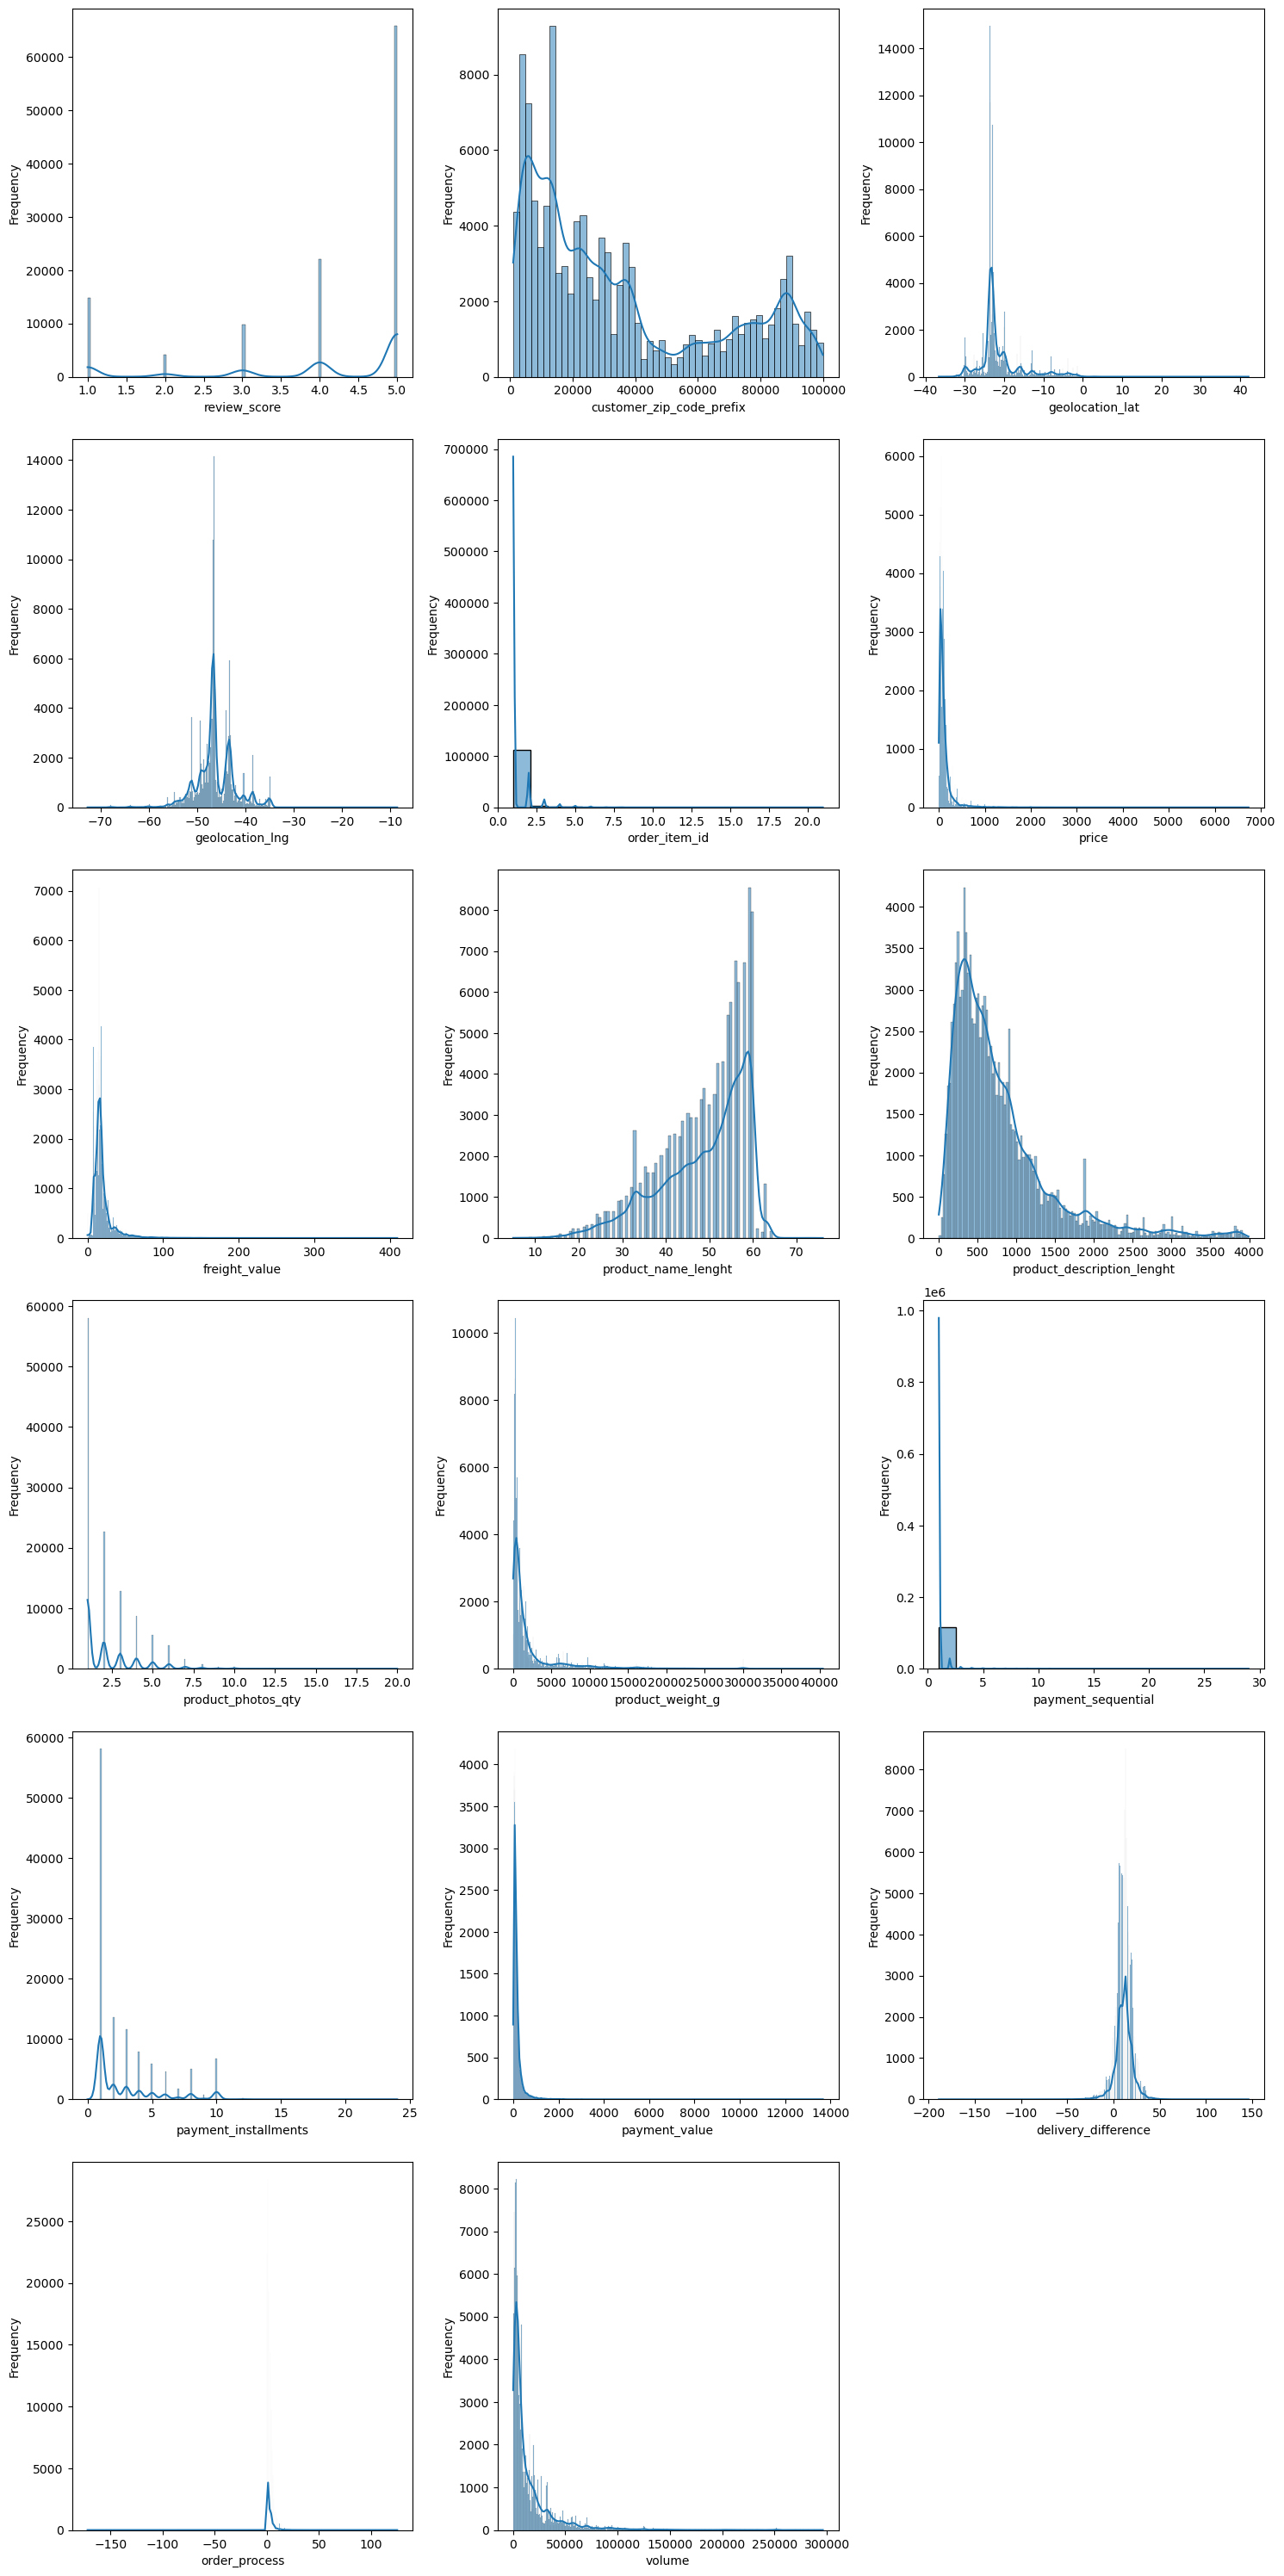

In [16]:
df_numerical = df_merged.select_dtypes(include='number')

# Calculate the number of rows needed for the subplots (3 columns per row)
n_rows = int(np.ceil(len(df_numerical.columns) / 3))

# Create subplots
fig, ax = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))  # Adjust the figure size as needed

ax_flat = ax.flatten()

for k, col in enumerate(df_numerical.columns):
    sns.histplot(df_numerical[col], ax=ax_flat[k], kde=True)
    ax_flat[k].set_xlabel(col)
    ax_flat[k].set_ylabel('Frequency')

for k in range(len(df_numerical.columns), len(ax_flat)):
    ax_flat[k].set_visible(False)

plt.tight_layout(pad=1)
plt.show()

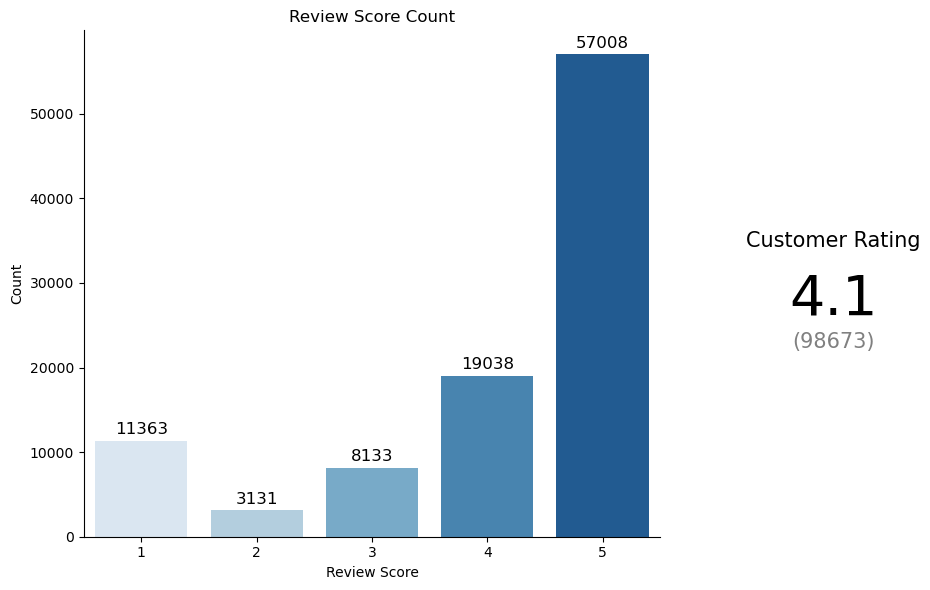

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 6))

# Count the frequency of each review score
data = df_orderss['review_score'].value_counts()

plots = sns.barplot(x=data.index, y=data, palette='Blues')
sns.despine(top=True, right=True)


for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center', 
                   size=12, xytext=(0, 8), 
                   textcoords='offset points')

plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Review Score Count')

avg_score = round(df_orderss['review_score'].mean(), 1)
total_count = df_orderss['review_score'].count()
plt.text(6, 35000, 'Customer Rating', fontsize=15, ha='center', va='center')
plt.text(6, 28000, f'{avg_score}', fontsize=40, ha='center', va='center')
plt.text(6, 23000, f'({total_count})', fontsize=15, ha='center', va='center', color='grey')
plt.tight_layout()

# Show plot
plt.show()


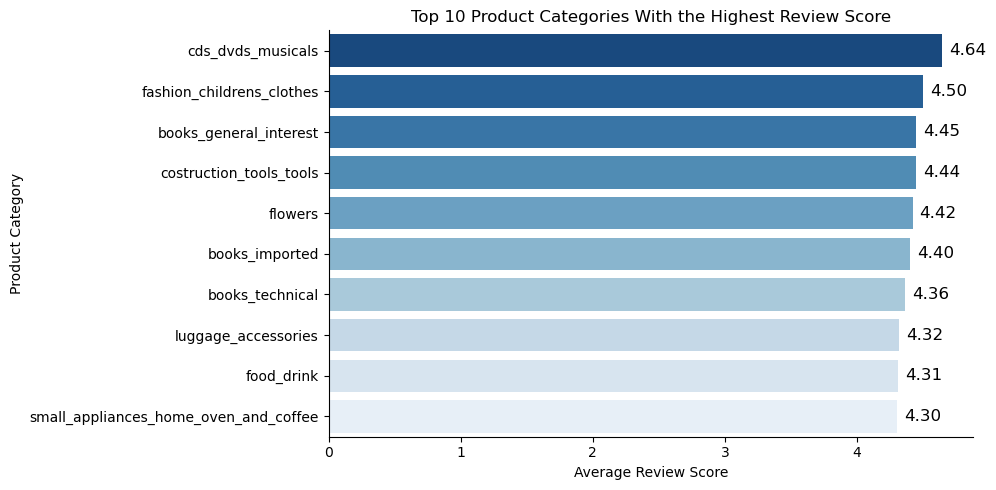

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


avg_review_scores = df_order_plus.groupby('product_category_name')['review_score'].mean().reset_index()
top_categories = avg_review_scores.sort_values('review_score', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plots = sns.barplot(data=top_categories, x='review_score', y='product_category_name', palette='Blues_r')

plt.title('Top 10 Product Categories With the Highest Review Score')
plt.xlabel('Average Review Score')
plt.ylabel('Product Category')
sns.despine(top=True, right=True)

for bar in plots.patches:
    plots.annotate(format(bar.get_width(), '.2f'), 
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                   ha='left', va='center', 
                   size=12, xytext=(5, 0), 
                   textcoords='offset points')

plt.tight_layout()
plt.show()


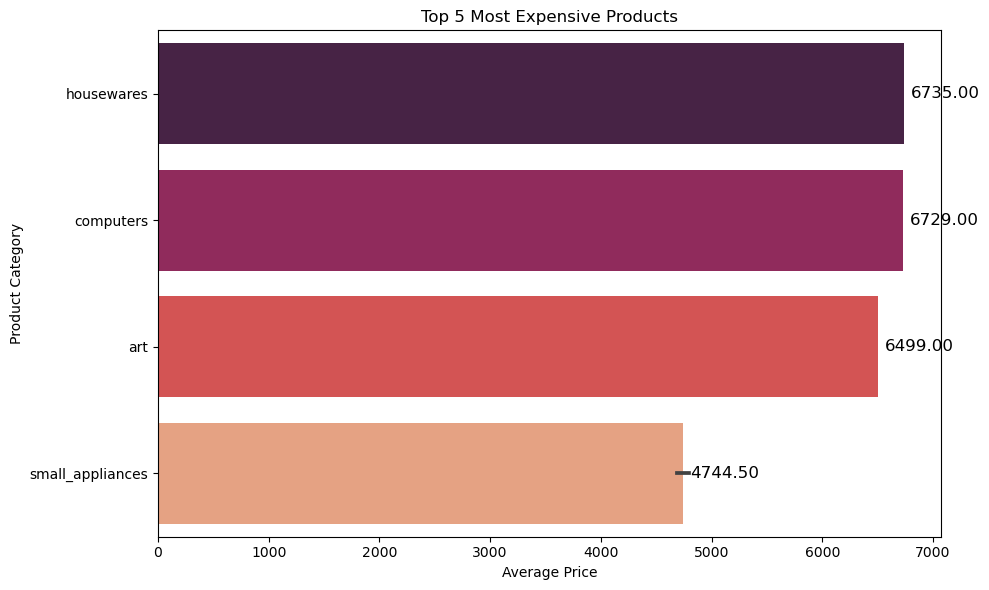

In [19]:
avg_product_prices = df_order_itemss.groupby(['product_id', 'product_category_name'])['price'].mean().reset_index()
top_expensive_products = avg_product_prices.sort_values('price', ascending=False).head(5)

plt.figure(figsize=(10, 6))
plots = sns.barplot(data=top_expensive_products, x='price', y='product_category_name', palette='rocket')

# Set plot title and labels
plt.title('Top 5 Most Expensive Products')
plt.xlabel('Average Price')
plt.ylabel('Product Category')

# Annotate each bar with its value
for bar in plots.patches:
    plots.annotate(format(bar.get_width(), '.2f'), 
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                   ha='left', va='center', 
                   size=12, xytext=(5, 0), 
                   textcoords='offset points')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

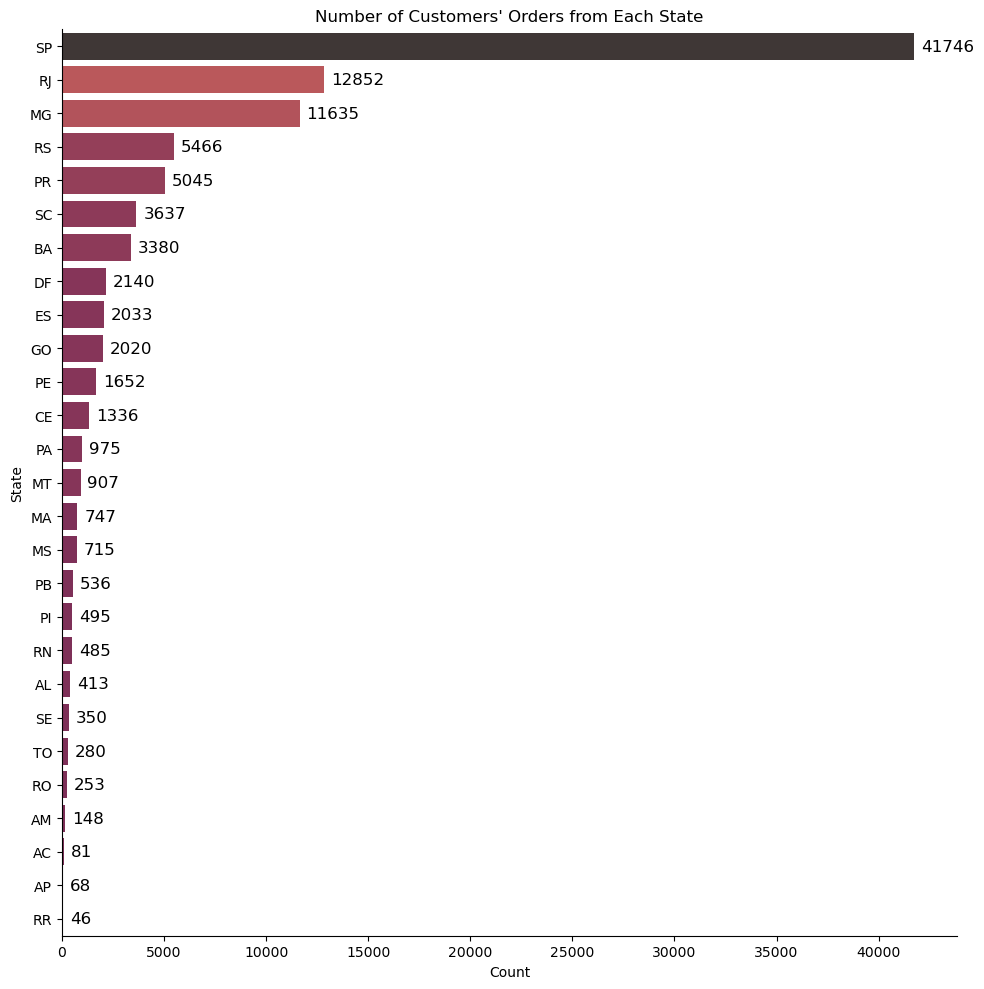

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(int)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

# Count the frequency of each state
data = df_customers['customer_state'].value_counts()

plt.figure(figsize=(10, 10))
plots = sns.barplot(x=data, y=data.index, palette=colors_from_values(data, 'rocket_d'))
sns.despine(top=True, right=True, left=False, bottom=False)

for bar in plots.patches:
    plots.annotate(format(bar.get_width(), '.0f'), 
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                   ha='left', va='center', 
                   size=12, xytext=(5, 0), 
                   textcoords='offset points')

plt.title("Number of Customers' Orders from Each State")
plt.xlabel('Count')
plt.ylabel('State')

plt.tight_layout()
plt.savefig('customer_state.png', transparent=True)

# Show the plot
plt.show()


In [21]:
# Group by state and product, then count the occurrences
popular_items = df_merged.groupby(['customer_state', 'product_id']).size().reset_index(name='count')

# Determine the most popular item for each state
popular_items = popular_items.sort_values(['customer_state', 'count'], ascending=[True, False])
most_popular_items = popular_items.drop_duplicates(subset='customer_state')
state_popular_item = most_popular_items[['customer_state', 'product_id']]



In [22]:
state_geo = df_geo.groupby('geolocation_state').agg(
    latitude=('geolocation_lat', 'mean'),
    longitude=('geolocation_lng', 'mean')
).reset_index()
# popular_items = df_merged.groupby(['customer_state', 'product_id']).size().reset_index(name='count')
# popular_items = popular_items.sort_values(['customer_state', 'count'], ascending=[True, False])
# most_popular_items = popular_items.drop_duplicates(subset='customer_state')
# state_data = pd.merge(state_geo, most_popular_items, left_on='geolocation_state', right_on='customer_state')


popular_items_with_names = pd.merge(popular_items, df_products[['product_id', 'product_category_name']], on='product_id', how='left')
state_product_data = df_merged.groupby(['customer_state', 'product_id']).size().reset_index(name='count')
state_product_data = pd.merge(state_product_data, df_products[['product_id', 'product_category_name']], on='product_id', how='left')
popular_items = state_product_data.sort_values(['customer_state', 'count'], ascending=[True, False])
most_popular_items = popular_items.drop_duplicates(subset='customer_state')
state_data = pd.merge(state_geo, most_popular_items, left_on='geolocation_state', right_on='customer_state')


In [17]:
# import folium

# # Create a map centered on Brazil
# brazil_map = folium.Map(location=[-14.235004, -51.92528], zoom_start=4)

# # Add markers to the map
# for _, row in state_data.iterrows():
#     tooltip_text = f"State: {row['customer_state']}<br>Most Popular Item: {row['product_id']}"
#     folium.Marker(
#         location=[row['latitude'], row['longitude']],
#         tooltip=tooltip_text
#     ).add_to(brazil_map)

# # Display the map
# brazil_map.save('brazil_popular_items_map.html')
# brazil_map






In [26]:
# Create a map centered on Brazil
brazil_map = folium.Map(location=[-14.235004, -51.92528], zoom_start=4)

# Add markers to the map
for _, row in state_data.iterrows():
    tooltip_text = f"State: {row['customer_state']}<br>Most Popular Item: {row['product_category_name']}"
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        tooltip=tooltip_text
    ).add_to(brazil_map)

# Display the map
brazil_map.save('brazil_popular_products_map.html')
brazil_map



In [27]:
customers_per_state = df_customers['customer_state'].value_counts().reset_index()
customers_per_state.columns = ['state', 'num_customers']
state_data = pd.merge(state_geo, customers_per_state, left_on='geolocation_state', right_on='state')
import folium

# Create the base map
brazil_map = folium.Map(location=[-14.235004, -51.92528], zoom_start=4)

for _, row in state_data.iterrows():
    tooltip_text = f"State: {row['state']}<br>" \
                   f"Number of Customers: {row['num_customers']}"
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        tooltip=tooltip_text
    ).add_to(brazil_map)

brazil_map.save('brazil_state_data_map.html')
brazil_map

In [29]:
scaler = MinMaxScaler(feature_range=(5, 50))  
customers_per_state['normalized_customers'] = scaler.fit_transform(customers_per_state[['num_customers']])
state_data = pd.merge(state_geo, customers_per_state, left_on='geolocation_state', right_on='state')
cmap = plt.cm.get_cmap('YlOrRd')
brazil_map = folium.Map(location=[-14.235004, -51.92528], zoom_start=4)

for _, row in state_data.iterrows():
    if 'normalized_customers' in row:
        color = cmap(row['normalized_customers'] / max(state_data['normalized_customers']))
        hex_color = '#%02x%02x%02x' % (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))

        tooltip_text = f"State: {row['state']}<br>" \
                       f"Number of Customers: {row['num_customers']}"

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=row['normalized_customers'],  # Size based on normalized customers
            color=hex_color,
            fill=True,
            fill_color=hex_color,
            fill_opacity=0.7,
            tooltip=tooltip_text
        ).add_to(brazil_map)


brazil_map


C:\Users\atayc\AppData\Local\Temp\ipykernel_20468\2052857014.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


## Clustering

In [10]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116623 entries, 0 to 116622
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       116623 non-null  object        
 1   customer_id                    116623 non-null  object        
 2   order_status                   116623 non-null  object        
 3   order_purchase_timestamp       116623 non-null  datetime64[ns]
 4   order_approved_at              116608 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115397 non-null  datetime64[ns]
 6   order_delivered_customer_date  114173 non-null  datetime64[ns]
 7   order_estimated_delivery_date  116623 non-null  datetime64[ns]
 8   review_id                      116623 non-null  object        
 9   review_score                   116623 non-null  int64         
 10  review_comment_title           13871 non-null   object        
 11  

In [11]:
#we will drom the categorical objects as there are no more useful
df_num = df_merged.select_dtypes('number').drop(['customer_zip_code_prefix','geolocation_lat','geolocation_lng'],axis=1)

In [12]:
df_num.isnull().sum()

review_score                     0
order_item_id                    0
price                            0
freight_value                    0
product_name_lenght           1684
product_description_lenght    1684
product_photos_qty            1684
product_weight_g                20
payment_sequential               0
payment_installments             0
payment_value                    0
delivery_difference           2450
order_process                 1226
volume                          20
dtype: int64

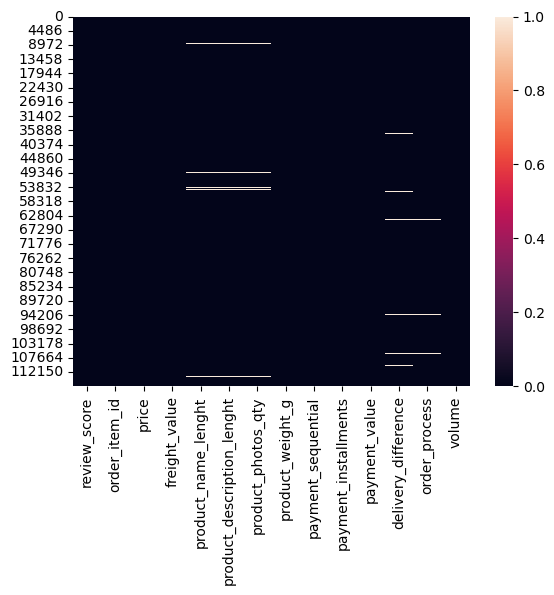

In [13]:
sns.heatmap(df_num.isnull())
plt.show()

In [14]:
df_num = df_num.apply(lambda x:x.fillna(x.median()),axis=0)

In [15]:
#we also drop ordinal features
df_num2 = df_num.drop(['review_score','order_item_id','payment_sequential'],axis=1)
df_num2

,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_installments,payment_value,delivery_difference,order_process,volume
0,29.99,8.72,40.0,268.0,4.0,500.0,1,18.12,7.0,2.0,1976.0
1,29.99,8.72,40.0,268.0,4.0,500.0,1,2.00,7.0,2.0,1976.0
2,29.99,8.72,40.0,268.0,4.0,500.0,1,18.59,7.0,2.0,1976.0
3,118.70,22.76,29.0,178.0,1.0,400.0,1,141.46,5.0,1.0,4693.0
4,159.90,19.22,46.0,232.0,1.0,420.0,3,179.12,17.0,0.0,9576.0
...,...,...,...,...,...,...,...,...,...,...,...
116618,174.90,20.10,52.0,828.0,4.0,4950.0,3,195.00,1.0,1.0,16000.0
116619,205.99,65.02,51.0,500.0,2.0,13300.0,5,271.01,5.0,1.0,63360.0
116620,179.99,40.59,59.0,1893.0,1.0,6550.0,4,441.16,20.0,3.0,8000.0
116621,179.99,40.59,59.0,1893.0,1.0,6550.0,4,441.16,20.0,3.0,8000.0


In [16]:
#From analysis we made our data has a lot of outliers so we will use Robust scaler to reduce the effect of them
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(df_num2)
df_pre = scaler.transform(df_num2)

### PCA

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=df_pre.shape[1])
pca.fit(df_pre)
df_pca = pca.transform(df_pre)
pd.DataFrame(pca.explained_variance_ratio_*100)

,0
0,46.570271
1,18.859276
2,6.949748
3,5.941040
4,4.408814
5,3.898063
6,3.604919
7,2.876690
8,2.708309
9,2.381707


In [38]:
pca = PCA(n_components=2)
pca.fit(df_pre)

df_pca = pca.transform(df_pre)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1
0,-2.497384,-0.413145
1,-2.546758,-0.490978
2,-2.495944,-0.410875
3,-1.033203,0.423879
4,-0.784713,0.875990


### Elbow method to chose clusters

In [39]:
from sklearn.cluster import KMeans
k = range(1,11)
inertia = []

for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

c:\Users\atayc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-9:
Traceback (most recent call last):
  File "c:\Users\atayc\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\atayc\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\atayc\anaconda3\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\atayc\anaconda3\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
c:\Users\atayc\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could

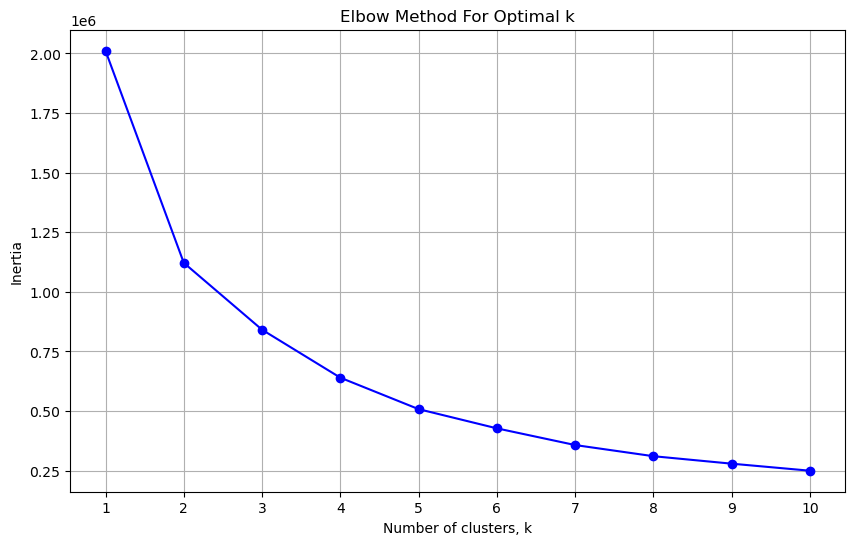

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(k, inertia, '-o', color='blue')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k)
plt.grid(True)

plt.show()

### Silhuette score

In [36]:
#It takes so long

# from sklearn.metrics import silhouette_score
# k = range(2,6)
# score = []

# for i in k:
#     kmeans = KMeans(n_clusters=i)
#     labels = kmeans.fit_predict(df_pca)
#     score.append(silhouette_score(df_pca, labels))

In [ ]:
# plt.figure(figsize=(8,5))

# sns.scatterplot(x=k, y=score)
# sns.lineplot(x=k,y=score)
# plt.grid(True)
# plt.title('Silhouette Score vs Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.xlabel('Number of Clusters')

# for x,y in zip(k,score):
#     label = "{:.2f}".format(y)
#     plt.annotate(label,
#                  (x,y),
#                  textcoords="offset points",
#                  xytext=(0,5),
#                  ha='center')
# plt.tight_layout()
# plt.show()

c:\Users\atayc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


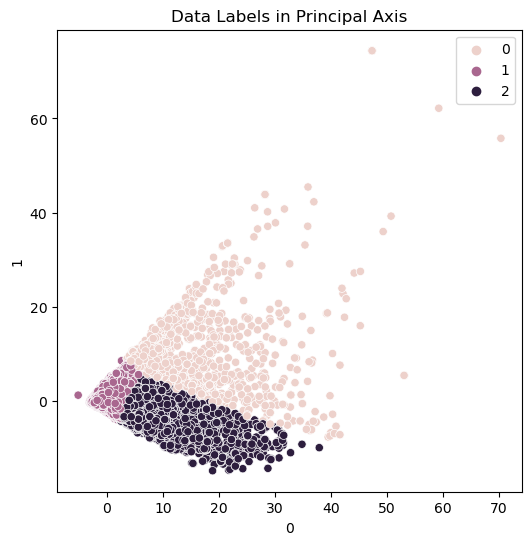

In [41]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_pca)
labels = kmeans.labels_
plt.figure(figsize=(6,6))
sns.scatterplot(x=df_pca[0],y=df_pca[1],hue=labels)
plt.title('Data Labels in Principal Axis')
plt.show()

In [39]:
df_merged['labels'] = labels
result = df_merged.groupby('labels').mean()[['price','freight_value','product_weight_g','volume','payment_installments']].reset_index()
result

,labels,price,freight_value,product_weight_g,volume,payment_installments
0,0,1147.520690,54.361032,7255.230992,45058.614045,6.241299
1,1,94.650302,17.092502,1141.489738,10272.553742,2.767260
2,2,220.954260,45.966180,11750.173500,65470.205102,4.184240


Here we have 3 groups of customers:
* Class 0: customers who bought expensive and medium (in terms of dimension and weight) products. This class of customers also pays with a high number of payment installments. This type of customer tends to buy expensive products thus we can call it **Expensive Product Buyers**.
* Class 1: customers who bought cheap, light, and small products. This class of customers also pays with a low number of payment installments. This type of customer tends to buy cheap and small products thus we can call it **Cheap Product Buyers**.
* Class 2: customers who bought the middle expensive, heavy, and large product. This class of customers also pays with a medium number of payment installments. This type of customers tends to buy a large and heavy product thus we can call it **Heavy Product Buyers**.